* Note that k_1 in this notebook is calculated by the s array that has variations (shoule use the average s?)

In [80]:
import numpy as np
import math
import os
import glob
import pandas as pd
from pylab import *
from netCDF4 import Dataset
import pylab as pl
from mpl_toolkits.basemap import Basemap,shiftgrid,cm
import matplotlib.cm as cm
from scipy.stats import f as scist

import numpy
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
% matplotlib inline

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

x = np.linspace(0,4,50)
y = func(x, 2.5, 1.3, 0.5)
yn = y + 0.2*np.random.normal(size=len(x))

popt, pcov = curve_fit(func, x, yn)

#Fitting the part. Th

In [82]:
import glob,csv
nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/*.csv'))
print len(nc_filename)
print("found *.csv file: \n{}".format(nc_filename))

12
found *.csv file: 
['/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/60changed.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/60changed2.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/60changed3.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/60changed4.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/60changed6.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/IC_d_1_ref5.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/IC_d_Pacific_lat52.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/IC_d_Pacific_lat53.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/IC_d_p_32_1.csv

In [83]:
file_num=5
marker=['s','s','s','s','s']
col=['g','g','orange','g','purple']

WLS_err1=np.empty([file_num,1])
WLS_coef1=np.empty([file_num,1])
WLS_errc=np.empty([file_num,1])
WLS_coefc=np.empty([file_num,1])
sinking_rate=np.empty([file_num,1])

err1=np.empty([file_num,1])
err2=np.empty([file_num,1])

rss1=np.empty([file_num,1])
rss2=np.empty([file_num,1])

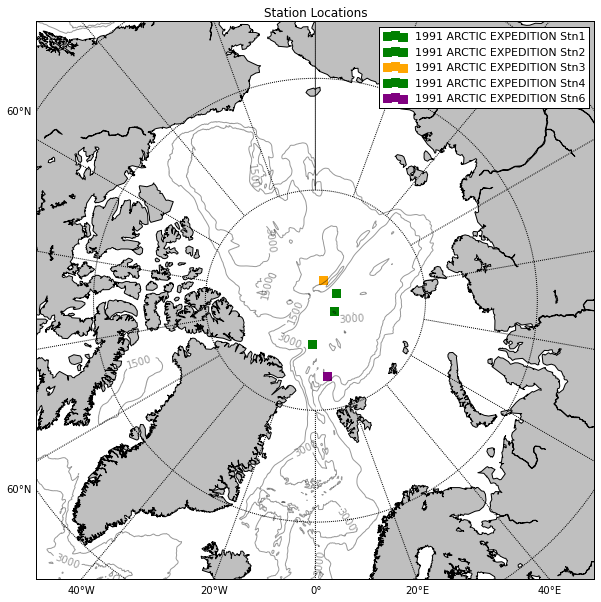

In [84]:
# map

import matplotlib.cm as cm

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

# create Basemap instance.
m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.75')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    lon = data['long.'];
    name= data['name'][0];
    lat = data['lat.'];
    x,y = m(lon.values,lat.values)
    m.scatter(x,y,color=col[j],marker=marker[j],s=70,label=name)


url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo5.nc'
etopodata = Dataset(url)
topoin = -etopodata.variables['ROSE'][:]
topoin_ma=np.ma.masked_where(topoin<=0,topoin)
lons = etopodata.variables['ETOPO05_X'][:]
lats = etopodata.variables['ETOPO05_Y'][:]
gridx, gridy = np.meshgrid(lons, lats)
xs,ys = m(gridx,gridy)  

m = m.contour(xs,ys,topoin_ma,linewidth=0.075,colors='black',alpha=0.4)
plt.clabel(m, fontsize=10, inline=1,fmt = '%1.0f')

plt.title("Station Locations")
plt.legend(loc=1,fontsize=11)

plt.show()

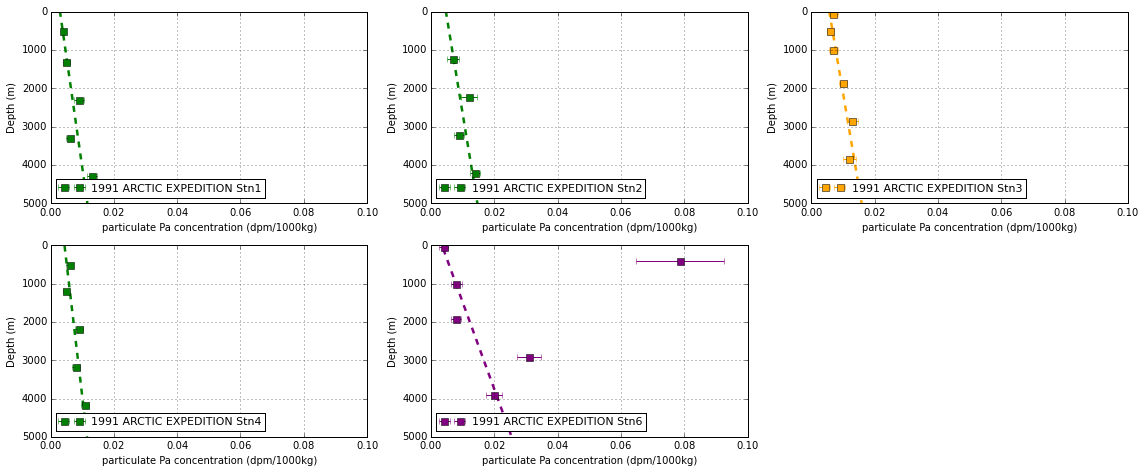

In [85]:
for j in range(file_num):

    data=pd.read_csv(nc_filename[j])

    y0= np.array(data['depth']);x0=np.array(data['231Pa part.']);
    lon = data['long.'];lat = data['lat.'];name= data['name'][0];
    err0 =data['Pa_part_err']
    
    x=np.ma.masked_where(x0<=0,x0); y=np.ma.masked_where(x0<=0,y0)
    err=np.ma.masked_where(x0<=0,err0)
    x=x.compressed();y=y.compressed();err=err.compressed()
    
    
    
    y2 = sm.add_constant(y,prepend=False)

    part_wls = sm.WLS(x, y2, weights=1./err**2).fit() #have intercept
    ftest   = sm.WLS(x, y, weights=1./err**2).fit()  #do not have intercept


    model1=np.sum(ftest.resid**2/err**2)
    model2=np.sum(part_wls.resid**2/err**2)
    rss1[j]=model1
    rss2[j]=model2
    
    p1 = 1
    p2 = 2
    n = len(x)
    F = ( model1 - model2)/model2*(n-p2)/(p2-p1)
    p = 1.0 - scist.cdf(F,p2-p1,n-p2)
    
    WLS_err1[j,:] = part_wls.bse[0]
    WLS_coef1[j,:] = part_wls.params[0]
    WLS_coefc[j,:]=part_wls.params[1]
    WLS_errc[j,:] = part_wls.bse[1]
    sinking_rate[j]=0.00246/part_wls.params[0]
    pre_err1=0.00246/(WLS_coef1[j,:]-WLS_err1[j,:])
    err1[j]=pre_err1-sinking_rate[j]

    
    ax = plt.figure(1,figsize=(16,16))
    ax = plt.subplot(5,3,j+1)
    cc=cm.Set1(j*23)#Spectral(j*23)
    ax.plot([0, 0.3],[0, 0.3]/part_wls.params[0]-part_wls.params[1]/part_wls.params[0],\
            '--.',c=col[j],linewidth=2.5)#,label='df2')
    ax.errorbar(x, y,xerr=err, fmt=marker[j],markersize=7,c=col[j],label=name)
    
    ax.legend(loc=3,fontsize=11)
    
    ax.set_ylim([0, 5000])
    ax.set_xlim([0, 0.1])
    plt.ylabel('Depth (m)')
    plt.xlabel('particulate Pa concentration (dpm/1000kg)')

    plt.gca().invert_yaxis()
    plt.grid()
    plt.tight_layout()

plt.show()

#fitting the diss. Th

####(1) Change into fit Q-C{1}K{-1}-K{-1}Qz/S

In [86]:
WLS_err2=np.empty([file_num,1]);

Kvalue=np.empty([file_num,1]); err2=np.empty([file_num,1])
Kvalue_=np.empty([file_num,1]);err2_=np.empty([file_num,1])
Jvalue_=np.empty([file_num,1]);err3_=np.empty([file_num,1])

Jvalue=np.empty([file_num,1])
WLS_coef2=np.empty([file_num,1])
Kapa=np.empty([file_num,1])

[ 0.01045738] [ 0.0053314] [ 0.01666227] [ 0.0027457]
[ 0.00991747] [ 0.0118492] [ 0.0254432] [ 0.01805071]
[ 0.00454194] [ 0.001847] [ 0.01876626] [ 0.01322268]
[ 0.00912052] [ 0.00406297] [ 0.01839402] [ 0.00405358]
[ 0.01454935] [ 0.01771797] [ 0.02689976] [ 0.00703926]


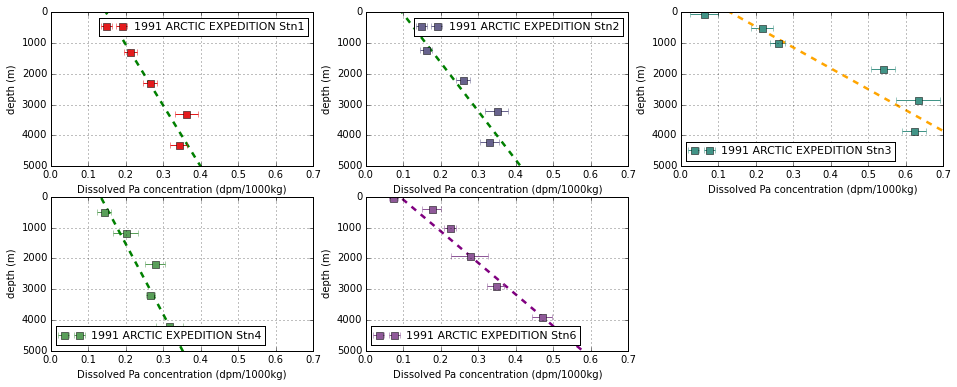

In [87]:
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    
    y0= data['depth'];
    x0= data['231Pa diss.'];
    name= data['name'][0];
    lon = data['long.'];
    lat = data['lat.'];
    err0 =data['Pa_diss_err']

    x=np.ma.masked_where(x0<=0,x0)
    y=np.ma.masked_where(x0<=0,y0)
    err=np.ma.masked_where(x0<=0,err0)
    
    x=x.compressed()
    y=y.compressed()
    err=err.compressed()


    y2=y
    
    #fit: model2
    y3 = sm.add_constant(y2,prepend=False)  
    diss_wls = sm.WLS(x,y3, weights=1./err**2).fit() 

    
    Q=0.00246
    a=diss_wls.params[0] #slope
    b=diss_wls.params[1] #cons.
    
    Kvalue[j] =Q**2/(b*Q+WLS_coefc[j,:]*a*sinking_rate[j])

    
    Kvalue_[j]=Q/b
    err2_[j]=Q/(b-diss_wls.bse[1])-Kvalue_[j]
    

    
    pre=Q**2/((b*Q+WLS_coefc[j,:]*a*sinking_rate[j])**2)
    pre_err2=abs(Q*pre*diss_wls.bse[1])+abs(a*WLS_coefc[j,:]*pre*err1[j])+abs(a*sinking_rate[j]*WLS_errc[j,:]*pre)
    err2[j]=pre_err2
    
    print Kvalue[j],err2[j],Kvalue_[j],err2_[j]
    
    
    Jvalue[j]=a*sinking_rate[j]/Q*Kvalue[j]
    Jvalue_[j]=a*sinking_rate[j]/Q*Kvalue_[j]

    err3=abs(Kvalue[j]*sinking_rate[j]/Q*diss_wls.bse[0])\
        +abs(a*sinking_rate[j]/Q*err2[j])+abs(a*Kvalue[j]/Q*err1[j])
        
    err3_[j]=diss_wls.bse[0]/diss_wls.params[0]*Jvalue_[j]


    
    WLS_coef2[j]=diss_wls.params[0]
    WLS_err2[j]=diss_wls.bse[0]
    #err2=diss_wls.bse[0]/diss_wls.params[0]*Kvalue[j]
    
    #fit: model1
    ftest=sm.WLS(x, y2, weights=1./err**2).fit()     
    
    #calculate weighted resid. sum
    resid1=ftest.resid**2/err**2                
    model1=np.sum(resid1)

    resid2=diss_wls.resid**2/err**2
    model2=np.sum(resid2)
    
    #prepare data to recalculate the whole profile later
    rss1[j]=model1                
    rss2[j]=model2

    #f_test
    p1 = 1
    p2 = 2
    n = len(x)
    F = (model1 - model2)/model2*(n-p2)/(p2-p1)
    p = 1.0 - scist.cdf(F,p2-p1,n-p2)

    
    #plot
    ax = plt.figure(1,figsize=(16,16))
    ax = plt.subplot(5,3,j+1)
    cc=cm.Set1(j*23)
    #ax.plot(y2, diss_wls.fittedvalues, '--.',c=cc,linewidth=1.5,label='df2')
    ax.plot([0, 1.4],[0, 1.4]/diss_wls.params[0]-diss_wls.params[1]/diss_wls.params[0], '--.',c=col[j],linewidth=2.5)
 
    ax.errorbar(x,y2,xerr=err, fmt=marker[j],markersize=7,c=cc,label=name)

    ax.legend(loc=0,fontsize=11)

    ax.set_xlim([0, 0.7]);ax.set_ylim([0, 5000])
    plt.xlabel('Dissolved Pa concentration (dpm/1000kg)')
    plt.ylabel('depth (m)')
    plt.grid()
    plt.gca().invert_yaxis() 
plt.show()

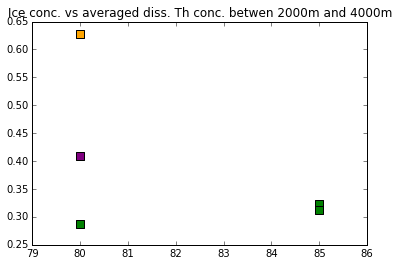

In [88]:
i= np.array([85,85,80,80,80]) 
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    
    y0= data['depth'];
    x0= data['231Pa diss.'];
    name= data['name'][0];
    lon = data['long.'];
    lat = data['lat.'];
    err0 =data['Pa_diss_err']

    x=np.ma.masked_where(x0<=0,x0)
    y=np.ma.masked_where(x0<=0,y0)
    err=np.ma.masked_where(x0<=0,err0)
    
    
    for num in range (len(y)):
        if y[num]<2000:
            x[num]=np.ma.masked
            y[num]=np.ma.masked
            err[num]=np.ma.masked
    cc=cm.Set1(j*23)        
    x=x.compressed()
    y=y.compressed()
    err=err.compressed()
    aver_x=np.average(x,axis=0)
    plt.scatter(i[j],aver_x,c=col[j],marker=marker[j],s=80)
    plt.hold(True)
    plt.title('Ice conc. vs averaged diss. Th conc. betwen 2000m and 4000m')
plt.show()

# WLS: sinking rate and the ice concentration

In [89]:
i= np.array([85,85,80,80,80]) # lowest in one point
i_summer=np.array([90,89,88,88.3,81.7])

err1=(WLS_err1/WLS_coef1)*1/WLS_coef1*0.00246
#sinking_rate=numpy.append(sinking_rate,500)
#i=numpy.append(i,0)
#i_summer=numpy.append(i_summer,0)
#err1=numpy.append(err1,0.0001)

i_=np.delete(i,-1)
i_summer_=np.delete(i_summer,-1)
sinking_rate_=np.delete(sinking_rate,-1)
err1_=np.delete(err1,-1)

print i_summer_
#i= np.array([96.4,95.2,91.2,88.8,97.2,98,98,97.6,97.6,95.6,95.2,97.2]) #poster
#marker=      ['o','o','o','o',   '^','s','s','s','s','s', 's','D','D','>']

[ 90.   89.   88.   88.3]


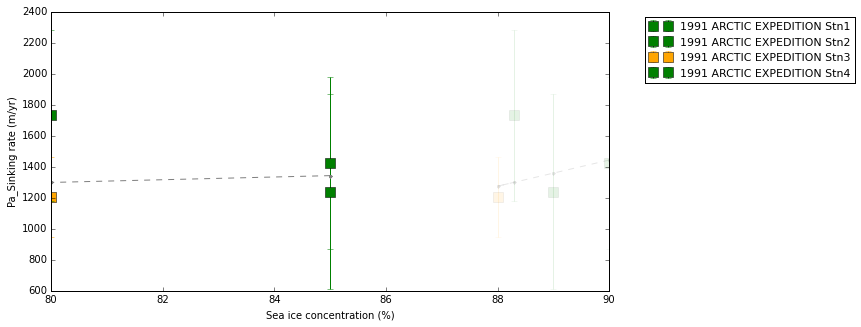

In [90]:
i2 = sm.add_constant(i_,prepend=False)
i_summer2 = sm.add_constant(i_summer_,prepend=False)

res_wls3 = sm.WLS(sinking_rate_,i2,weights=1./err1_**2).fit() 
summer = sm.WLS(sinking_rate_,i_summer2,weights=1./err1_**2).fit() 

_fig=plt.figure(figsize=(10,5));ax = _fig.add_subplot(111)
ax.plot(i_, res_wls3.fittedvalues, '--.',color='grey',alpha=1)
ax.plot(i_summer_, summer.fittedvalues, '--.',color='grey'  ,alpha=0.2)
for j in ([0,1,2,3]):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],sinking_rate[j],yerr=err1[j],fmt=marker[j],markersize=10,c=col[j],label=name)
    errorbar(i_summer[j],sinking_rate[j],yerr=err1[j],fmt=marker[j],markersize=10,c=col[j],alpha=0.1)

#ax.errorbar(i[-1],sinking_rate[-1], yerr=err1[-1], fmt='o',markersize=10,c='blue',label='previous model work')
ax.legend(loc=0, fontsize=11,bbox_to_anchor=(1.45,1))
plt.xlabel('Sea ice concentration (%)')
plt.ylabel('Pa_Sinking rate (m/yr)')

plt.show()

In [91]:
np.average(sinking_rate_)

1400.447619743451

#  K value and the ice concentration



** $x_d= \frac{1}{k}\left(Q+k_{-1} x_p \right )  = \frac{1}{k}\left(Q+k_{-1} \left(\frac{Q}{s}z +c_1\right)\right )$, where $c_1$ is the intercept from the particulate profiles.**


** The first equal sign:**

  using x_p data to fink k and k_1 will create negative values if the points that seems to be affected by advection are not removed.
  
  

** The second equal sign** (especially for the part of $\left(\frac{Q}{s}z +c_1\right)$):


### 1. Previous method: 

 The figure below shows the original fitting that keeps the variations in s and $c_1$ in different location.


**intercept = $\frac{Q+k_{-1}C_{1}}{k}$
slope     = $\frac{k_{-1}}{k}\frac{Q}{s}$**

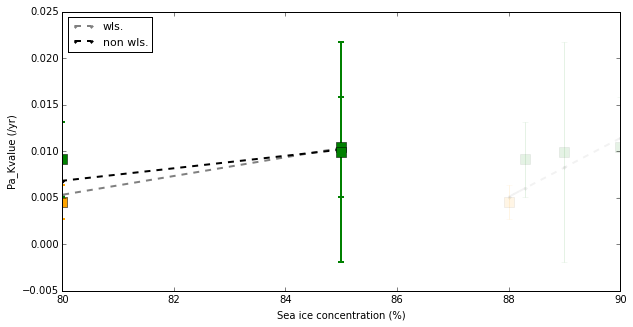

0.00100807989576 -0.0753203118847
0.000671238090505 -0.0468678142049


In [92]:
Kvalue__=np.delete(Kvalue,-1);err2__=np.delete(err2,-1)

res_wls4 = sm.WLS(Kvalue__, i2, weights=1./err2__**2).fit()
non_wls  = sm.WLS(Kvalue__, i2, weights=1).fit()
summer_k = sm.WLS(Kvalue__, i_summer2, weights=1./err2__**2).fit()

_fig=plt.figure(figsize=(10,5));ax = _fig.add_subplot(111)
ax.plot(i_, res_wls4.fittedvalues,  '--.',color='grey',lw=2,alpha=1,label='wls.')
ax.plot(i_, non_wls.fittedvalues,  '--.',color='black',lw=2,alpha=1,label='non wls.')
ax.plot(i_summer_, summer_k.fittedvalues,  '--.',color='grey',lw=2,alpha=0.1)

for j in ([0,1,2,3]):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],Kvalue[j],yerr=err2[j],fmt=marker[j],markersize=10,c=col[j],\
             elinewidth=2,capthick=2,alpha=1)#,label=name)
    errorbar(i_summer[j],Kvalue[j],yerr=err2[j],fmt=marker[j],markersize=10,c=col[j],alpha=0.1)
    
ax.legend(loc=0,fontsize=11)
plt.xlabel('Sea ice concentration (%)');plt.ylabel('Pa_Kvalue (/yr)');
plt.show()
#print res_wls4.summary() 
s=res_wls4.params[0] #slope
c=res_wls4.params[1] #cons.
s_=non_wls.params[0] #slope
c_=non_wls.params[1] #cons.
print s,c
print s_,c_

### 2. Current method


if we let s= avg(sinking rates), then it will be meaningless to consider $c_1$. So the figure shows the fitting with averged s=715m/y and $c_1$ is set to be 0.

$x_d= \frac{1}{k}\left(Q+k_{-1} \frac{Q}{\bar{s}}z\right )$ 

**intercept = $\frac{Q}{k}$   slope = $\frac{k_1}{k}\frac{Q}{s}$ **
  

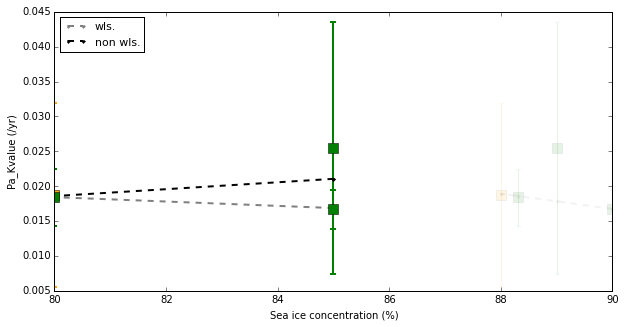

-0.000313032095905 0.0434685685148
0.000494518325129 -0.0209813227955


In [93]:
Kvalue__=np.delete(Kvalue_,-1);err2__=np.delete(err2_,-1)

res_wls4 = sm.WLS(Kvalue__, i2, weights=1./err2__**2).fit()
non_wls  = sm.WLS(Kvalue__, i2, weights=1).fit()
summer_k = sm.WLS(Kvalue__, i_summer2, weights=1./err2__**2).fit()

_fig=plt.figure(figsize=(10,5));ax = _fig.add_subplot(111)
ax.plot(i_, res_wls4.fittedvalues,  '--.',color='grey',lw=2,alpha=1,label='wls.')
ax.plot(i_, non_wls.fittedvalues,  '--.',color='black',lw=2,alpha=1,label='non wls.')
ax.plot(i_summer_, summer_k.fittedvalues,  '--.',color='grey',lw=2,alpha=0.1)

for j in ([0,1,2,3]):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],Kvalue_[j],yerr=err2_[j],fmt=marker[j],markersize=10,c=col[j],\
             elinewidth=2,capthick=2,alpha=1)#,label=name)
    errorbar(i_summer[j],Kvalue_[j],yerr=err2_[j],fmt=marker[j],markersize=10,c=col[j],alpha=0.1)
    
ax.legend(loc=0,fontsize=11)
plt.xlabel('Sea ice concentration (%)')
plt.ylabel('Pa_Kvalue (/yr)')
plt.show()
#print res_wls4.summary() 
s=res_wls4.params[0] #slope
c=res_wls4.params[1] #cons.
s_=non_wls.params[0] #slope
c_=non_wls.params[1] #cons.
print s,c
print s_,c_

In [99]:
np.average(Kvalue__)

0.019816439027591302

#  J value and the ice concentration

### 1. Previous method

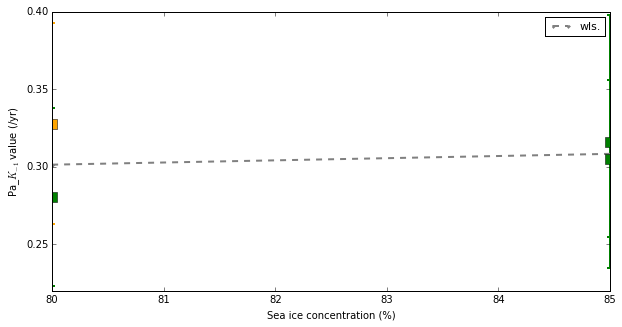

In [94]:
err2=WLS_err2/WLS_coef2*Jvalue
jvalue=np.delete(Jvalue,-1)
err2_=np.delete(err2,-1)

mod_wls4 = sm.WLS(jvalue, i2, weights=1./err2_**2).fit()

_fig=plt.figure(figsize=(10,5));ax = _fig.add_subplot(111)
ax.plot(i_, mod_wls4.fittedvalues,  '--.',color='grey',lw=2,alpha=1,label='wls.')

for j in ([0,1,2,3]):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],Jvalue[j],yerr=err2[j],fmt=marker[j],markersize=10,c=col[j],\
             elinewidth=2,capthick=2,alpha=1)#,label=name)
    
ax.legend(loc=0,fontsize=11)
plt.xlabel('Sea ice concentration (%)');plt.ylabel('Pa_$K_{-1}$ value (/yr)')

### 2. Current method

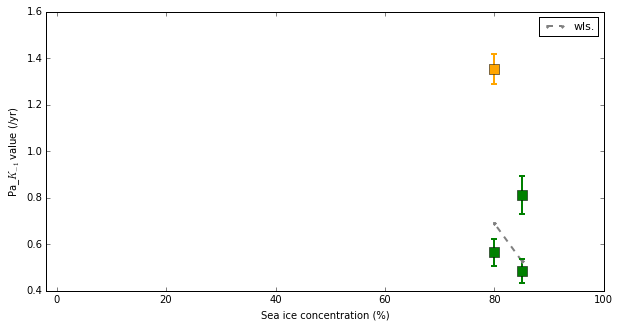

In [95]:
jvalue_=np.delete(Jvalue_,-1)
err3__=np.delete(err3_,-1)

mod_wls4 = sm.WLS(jvalue_, i2, weights=1./err3__**2).fit()


_fig=plt.figure(figsize=(10,5));ax = _fig.add_subplot(111)
ax.plot(i_, mod_wls4.fittedvalues,  '--.',color='grey',lw=2,alpha=1,label='wls.')

for j in ([0,1,2,3]):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],Jvalue_[j],yerr=err2[j],fmt=marker[j],markersize=10,c=col[j],\
             elinewidth=2,capthick=2,alpha=1)#,label=name)
    
ax.legend(loc=0,fontsize=11)
plt.xlabel('Sea ice concentration (%)');plt.ylabel('Pa_$K_{-1}$ value (/yr)');ax.set_xlim([-2, 100])
plt.show()

In [100]:
np.average(jvalue_)

0.80461336631643676

? Should the parameterization depend on s or not?

In [96]:
from pykrige.ok import OrdinaryKriging
x_interp=np.empty(4)
y_interp=np.empty(4)

nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Pa/*.csv'))
i=0
for j in ([0,1,2,3]):
    
    data=pd.read_csv(nc_filename[j])
    lon = data['long.'];
    name= data['name'][0];
    lat = data['lat.'];
    m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l')
    x,y = m(lon.values,lat.values)
    x_interp[i]=x[0]
    y_interp[i]=y[0]
    i=i+1

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'linear' Variogram Model
Slope: 7.86440728606e-07
Nugget: 0.00315596350499 



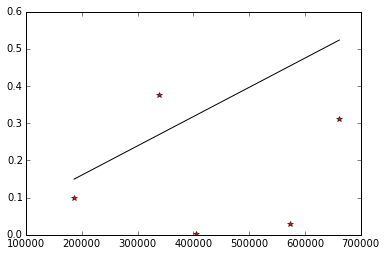

Calculating statistics on variogram model fit...
Q1 = 0.800461698281
Q2 = 0.734942790964
cR = 0.281310437925 

Updating variogram mode...
Using 'linear' Variogram Model
Slope: 7.86440728606e-07
Nugget: 0.00315596350499 



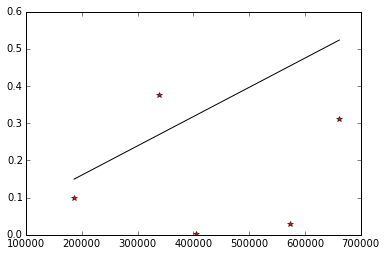

Calculating statistics on variogram model fit...
Q1 = 0.800461698281
Q2 = 0.734942790964
cR = 0.281310437925 

Executing Ordinary Kriging...



In [97]:
import netCDF4 as nc
OK = OrdinaryKriging(x_interp,y_interp,jvalue_, variogram_model='linear', verbose=True, enable_plotting=True)
OK.update_variogram_model('linear',nlags=100,anisotropy_angle=0)
coordinate_name=glob.glob('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/*coor*.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l')
x_lon,y_lat = m(nav_lon, nav_lat)

J_interp, ss = OK.execute('points',x_lon, y_lat)
J_interp=J_interp.reshape(nav_lon.shape)

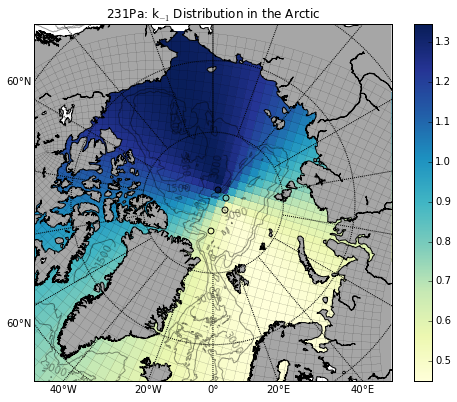

In [98]:
fig=plt.figure(figsize=(8, 8)); 
ax = fig.add_subplot()

# create Basemap instance.
m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.65')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])


CS = m.pcolor(x_lon[::10,::10],y_lat[::10,::10],J_interp[::10,::10],cmap=plt.cm.YlGnBu)#boundary+120
CBar = plt.colorbar(CS, shrink=0.8)
cmm = plt.cm.get_cmap('YlGnBu')
for j in range(len(y_interp)):    
    plt.scatter(x_interp[j],y_interp[j],c=jvalue_[j],vmin=np.min(J_interp),vmax=np.max(J_interp),cmap=cmm,s=Jvalue[j]*50+20)
    
    
plt.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon[::10,::10].T,y_lat[::10,::10].T,color='black',linewidth=0.1)


url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo5.nc'
etopodata = Dataset(url)
topoin = -etopodata.variables['ROSE'][:]
topoin_ma=np.ma.masked_where(topoin<=0,topoin)
lons = etopodata.variables['ETOPO05_X'][:]
lats = etopodata.variables['ETOPO05_Y'][:]
gridx, gridy = np.meshgrid(lons, lats)
xs,ys = m(gridx,gridy)  

m = m.contour(xs,ys,topoin_ma,linewidth=0.075,colors='black',alpha=0.4)
plt.clabel(m, fontsize=10, inline=1,fmt = '%1.0f')

plt.title('231Pa: k$_{-1}$ Distribution in the Arctic')
plt.legend(loc=1,fontsize=11)

plt.show()